# Final Project

David Basilio Rodriguez Cortez (s231486),   
Diego Jimenez Pasillas (s231479),   
Dana Georgiana Toma (s232042)


## Mount drive and load libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from glob import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
from keras.optimizers import Adam
from keras import backend as K
from keras.metrics import Mean

## Parameters

In [ ]:
# Input image size that we are going to use
IMAGE_SIZE = 256
# 3 classes (3 objects)
N_CLASSES = 3
# Set batch size
BATCH = 16
# Set learning rate
LR = 0.01
# Set dropout
DROPOUT = 0.3
# Set epoch
EPOCHS = 50
# Set main path
main_path = '/content/drive/MyDrive/DTU/DeepLearningDTU'


## Load data

In [ ]:
from sklearn.model_selection import train_test_split

# Functions to read image and mask paths to output numpy arrays
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE)) # shape = (128, 128)
    x = x/65535.0                               # [0, 1]
    x = np.expand_dims(x, axis=-1)              # shape = (128, 128, 1)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # {0, 127, 255}
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = (x/127.0).astype("uint8")
    x = np.expand_dims(x, axis=-1)              # shape = (128, 128, 1)
    return x

# Function to create lists of paths for training, validation and testing data
def load_data():
    X_path = sorted(glob(os.path.join(main_path, 'training_dataset/data', "*.tiff")))
    y_path = sorted(glob(os.path.join(main_path, 'training_dataset/labels', "*.tif")))

    X = np.array(list(map(read_image, X_path)))
    y = np.array(list(map(read_mask, y_path)))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=100, random_state=42)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [ ]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_data()

print("Training data: ", len(x_train))
print("Validation data: ", len(x_valid))
print("Test data: ", len(x_test))

Training data:  350
Validation data:  100
Test data:  50


In [ ]:
x_test.shape

(50, 256, 256, 1)

### Show sample

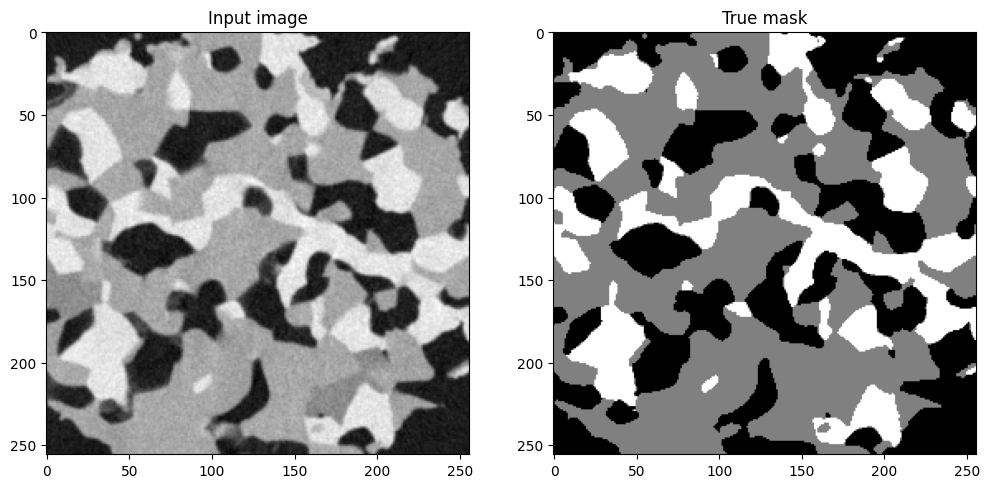

In [ ]:
fig = plt.figure(figsize=(12, 6))
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow((x_train[0]), cmap='gray')
plt.title('Input image')

a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow((y_train[0]), cmap='gray')
plt.title('True mask')

plt.show()

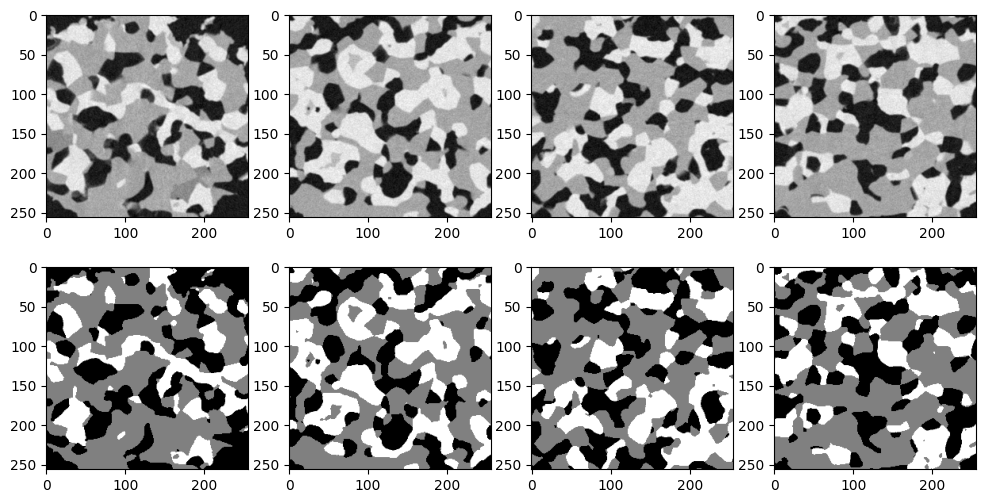

In [ ]:
# Plot samples of images and corresponding masks
fig = plt.figure(figsize=(12, 6))
a = fig.add_subplot(2, 4, 1)
imgplot = plt.imshow((x_train[0]), cmap='gray')

a = fig.add_subplot(2, 4, 2)
imgplot = plt.imshow((x_train[1]), cmap='gray')

a = fig.add_subplot(2, 4, 3)
imgplot = plt.imshow((x_train[2]), cmap='gray')

a = fig.add_subplot(2, 4, 4)
imgplot = plt.imshow((x_train[3]), cmap='gray')

a = fig.add_subplot(2, 4, 5)
imgplot = plt.imshow((y_train[0]), cmap='gray')

a = fig.add_subplot(2, 4, 6)
imgplot = plt.imshow((y_train[1]), cmap='gray')

a = fig.add_subplot(2, 4, 7)
imgplot = plt.imshow((y_train[2]), cmap='gray')

a = fig.add_subplot(2, 4, 8)
imgplot = plt.imshow((y_train[3]), cmap='gray')

plt.savefig(os.path.join(main_path, 'model_final', f'sample_truth.png'))

In [ ]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2]


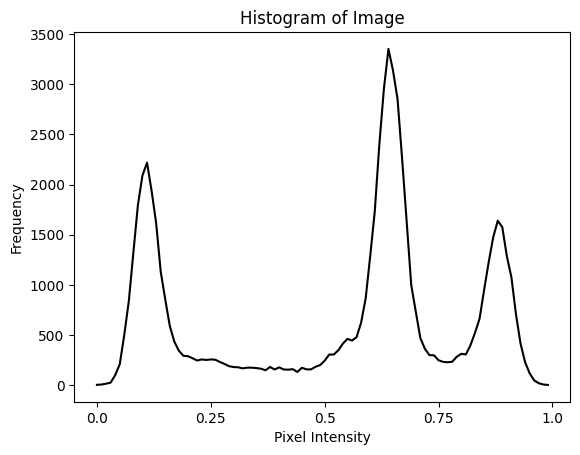

In [ ]:
histogram, _ = np.histogram(x_train[0].flatten(), bins=100)

plt.plot(histogram, color='black')
plt.xticks(np.linspace(0, 100, 5), np.linspace(0, 1, 5))

plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Image')
plt.savefig(os.path.join(main_path, 'model_final', f'histogram.png'))
plt.show()

In [ ]:
combined_array = np.concatenate((y_train, y_valid, y_test), axis=0)

# Count unique values
unique_values, counts = np.unique(combined_array, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count/counts.sum()}")

Value: 0, Count: 0.3049931945800781
Value: 1, Count: 0.43735284423828125
Value: 2, Count: 0.25765396118164063


In [ ]:
from keras.utils import to_categorical

train_masks_cat = to_categorical(y_train, num_classes=N_CLASSES)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], N_CLASSES))

valid_masks_cat = to_categorical(y_valid, num_classes=N_CLASSES)
y_valid_cat = valid_masks_cat.reshape((y_valid.shape[0], y_valid.shape[1], y_valid.shape[2], N_CLASSES))

test_masks_cat = to_categorical(y_test, num_classes=N_CLASSES)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], N_CLASSES))

In [ ]:
y_train_cat.shape

(350, 256, 256, 3)

## Define the model

In [ ]:
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1, DROPOUT=0.3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(DROPOUT)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(DROPOUT)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(DROPOUT)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(DROPOUT)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(DROPOUT)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(DROPOUT)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(DROPOUT)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(DROPOUT)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(DROPOUT)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

def get_model():
    return multi_unet_model(n_classes=N_CLASSES, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS, DROPOUT=DROPOUT)


In [ ]:
IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH  = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]

### Metrics

In [ ]:
def pixel_accuracy(y_true, y_pred):
    # Convert predicted probabilities to binary predictions
    y_pred_binary = K.round(y_pred)

    # Calculate pixel-wise accuracy
    correct_pixels = K.cast(K.equal(y_true, y_pred_binary), 'float32')
    accuracy = K.mean(correct_pixels)

    return accuracy

def mean_iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * K.round(y_pred)))
    union = K.sum(K.abs(y_true) + K.abs(K.round(y_pred)) - y_true * K.round(y_pred))
    iou = intersection / (union + K.epsilon())
    return iou

def dice_coefficient(y_true, y_pred):
    intersection = 2 * K.sum(K.abs(y_true * K.round(y_pred)))
    union = K.sum(K.abs(y_true) + K.abs(K.round(y_pred)))
    dice = intersection / (union + K.epsilon())
    return dice

# Define precision, recall, and F1 score
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value + K.epsilon())
    return f1

### Optimizer

In [ ]:
adam_optimizer = Adam(learning_rate=LR)

model = get_model()
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=[pixel_accuracy, mean_iou, dice_coefficient, precision, recall, f1_score])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

### Early stop and Reduce learning rate

In [ ]:
# Set up early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='max',
    start_from_epoch=30,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
)

### Train the model

#### Load model
(If the model has already been trained, proceed to load the model)

In [ ]:
from tensorflow.keras.models import load_model

def load_saved_model(saved_model_path):

  def pixel_accuracy(y_true, y_pred):
      # Convert predicted probabilities to binary predictions
      y_pred_binary = K.round(y_pred)

      # Calculate pixel-wise accuracy
      correct_pixels = K.cast(K.equal(y_true, y_pred_binary), 'float32')
      accuracy = K.mean(correct_pixels)

      return accuracy

  def mean_iou(y_true, y_pred):
      intersection = K.sum(K.abs(y_true * K.round(y_pred)))
      union = K.sum(K.abs(y_true) + K.abs(K.round(y_pred)) - y_true * K.round(y_pred))
      iou = intersection / (union + K.epsilon())
      return iou

  def dice_coefficient(y_true, y_pred):
      intersection = 2 * K.sum(K.abs(y_true * K.round(y_pred)))
      union = K.sum(K.abs(y_true) + K.abs(K.round(y_pred)))
      dice = intersection / (union + K.epsilon())
      return dice

  # Define precision, recall, and F1 score
  def precision(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision

  def recall(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

  def f1_score(y_true, y_pred):
      precision_value = precision(y_true, y_pred)
      recall_value = recall(y_true, y_pred)
      f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value + K.epsilon())
      return f1

  # Load the SavedModel
  model = load_model(saved_model_path, custom_objects={'pixel_accuracy': pixel_accuracy,
                                                      'mean_iou':mean_iou,
                                                      'dice_coefficient':dice_coefficient,
                                                      'precision':precision,
                                                      'recall':recall,
                                                      'f1_score':f1_score})

  return model

# Provide the path to the directory containing the saved_model.pb file
saved_model_path = os.path.join(main_path, 'model_final', 'saved_model.keras')

model = load_saved_model(saved_model_path)

#### Training
(If the model has not undergone training yet)

In [ ]:
history = model.fit(x_train, y_train_cat,
                    batch_size = BATCH,
                    verbose=1,
                    epochs=EPOCHS,
                    validation_data=(x_valid, y_valid_cat),
                    shuffle=False,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
22/22 [==============================] - 40s 694ms/step - loss: 1.3634 - pixel_accuracy: 0.6577 - mean_iou: 0.0983 - dice_coefficient: 0.1709 - precision: 0.4259 - recall: 0.1212 - f1_score: 0.1709 - val_loss: 0.9058 - val_pixel_accuracy: 0.6848 - val_mean_iou: 0.2393 - val_dice_coefficient: 0.3861 - val_precision: 0.5504 - val_recall: 0.2974 - val_f1_score: 0.3861 - lr: 0.0100
Epoch 2/50
22/22 [==============================] - 4s 197ms/step - loss: 0.8318 - pixel_accuracy: 0.6994 - mean_iou: 0.2214 - dice_coefficient: 0.3555 - precision: 0.6093 - recall: 0.2567 - f1_score: 0.3555 - val_loss: 0.6810 - val_pixel_accuracy: 0.8530 - val_mean_iou: 0.5812 - val_dice_coefficient: 0.7351 - val_precision: 0.9205 - val_recall: 0.6119 - val_f1_score: 0.7351 - lr: 0.0100
Epoch 3/50
22/22 [==============================] - 4s 191ms/step - loss: 0.6694 - pixel_accuracy: 0.8225 - mean_iou: 0.5472 - dice_coefficient: 0.7004 - precision: 0.7859 - recall: 0.6388 - f1_score: 0.7004 - val_los

In [ ]:
model.save(os.path.join(main_path, 'model_final', 'saved_model.keras'))

#### Show some results

In [ ]:
results = model.evaluate(x_test, y_test_cat, verbose=0)
dict(zip(model.metrics_names, results))

{'loss': 0.06370382010936737,
 'pixel_accuracy': 0.98283851146698,
 'mean_iou': 0.9497016072273254,
 'dice_coefficient': 0.9742017984390259,
 'precision': 0.9763236045837402,
 'recall': 0.9720892310142517,
 'f1_score': 0.9742017388343811}

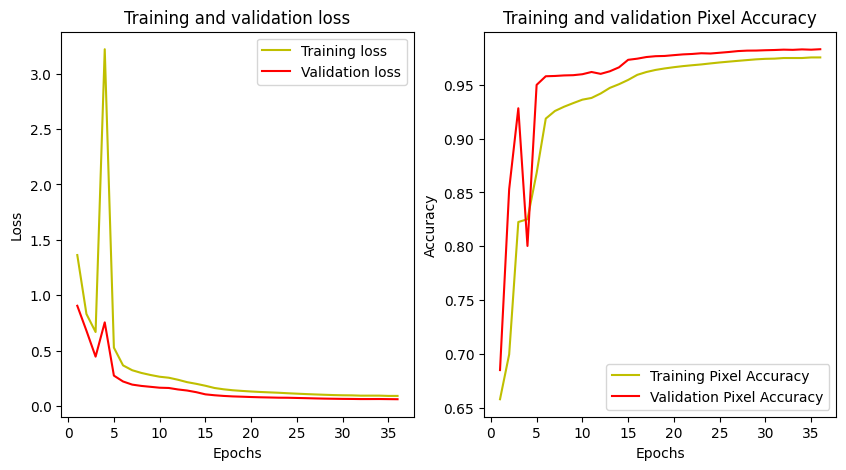

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['pixel_accuracy']
val_acc = history.history['val_pixel_accuracy']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'y', label='Training Pixel Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Pixel Accuracy')
plt.title('Training and validation Pixel Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig(os.path.join(main_path, 'model_final', f'model_metrics.png'))
plt.show()

### Prediction

In [ ]:
def visualize_difference(truth_mask, predicted_mask):
    # Calculate the absolute difference between truth_mask and predicted_mask.
    return np.abs(truth_mask - predicted_mask)

def display_sample(display_list):
    # Display a sample containing an input image, true mask, predicted mask, and their difference.
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(wspace=0.05, hspace=0.1)  # Adjust the spacing between subplots
    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Difference']
    for i in range(len(display_list)):
        plt.subplot(2, 2, i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
        plt.axis('off')

    difference_mask = visualize_difference(display_list[1], display_list[2])
    plt.subplot(2, 2, 4)
    plt.title(title[3])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(difference_mask))
    plt.axis('off')

    plt.savefig(os.path.join(main_path, 'model_final', f'prediction.png'))
    plt.show()

def create_mask(pred_mask):
    # Convert the predicted mask to a single-channel mask.
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    return pred_mask[0]

def prediction(sample_image):
    # Make a prediction for a sample image using the trained model.
    sample_image = np.expand_dims(sample_image, 0)
    prediction = model.predict(sample_image, verbose=0)
    pred_mask = create_mask(prediction)
    return pred_mask

def show_predictions(sample_image, sample_mask):
    # Display predictions for a sample image alongside the true mask.
    pred_mask = prediction(sample_image)
    display_sample([sample_image, sample_mask, pred_mask])

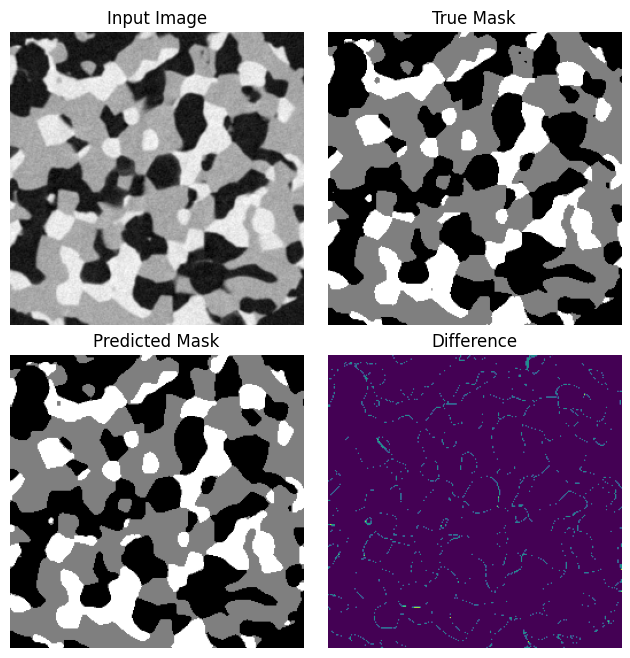

In [ ]:
sample_image = x_test[0]
sample_mask=y_test[0]

pred = prediction(sample_image)
show_predictions(sample_image, sample_mask)

In [ ]:
# Perform predictions on the test data
y_pred = model.predict(x_test, verbose=0)
y_pred.shape

(50, 256, 256, 3)

In [ ]:
y_test_cat.shape

(50, 256, 256, 3)

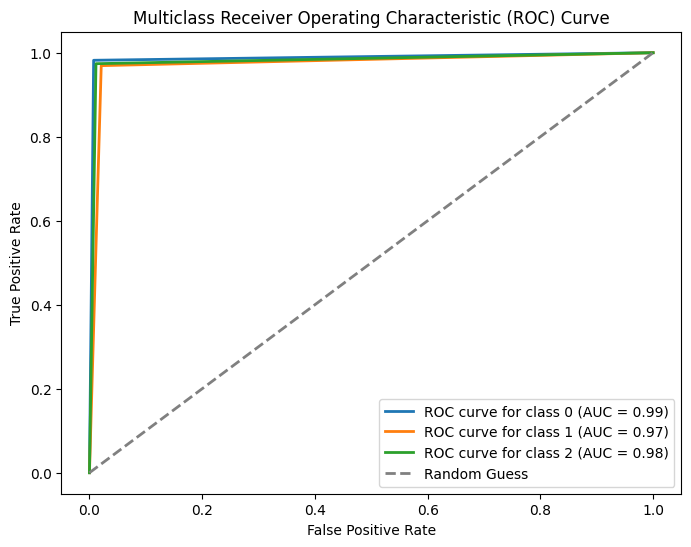

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Make predictions on the test set
y_pred = model.predict(x_test, verbose=0)
y_pred_cat = np.zeros_like(y_pred)

for j in range(y_pred.shape[0]):
    # Create a new 3D array with 1 at maximum value indices and 0 elsewhere
    arr_3d = y_pred[j]
    max_indices = np.argmax(arr_3d, axis=2)
    for i in range(arr_3d.shape[0]):
        y_pred_cat[j, i, np.arange(arr_3d.shape[1]), max_indices[i, :]] = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):  # Assuming 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:,:,:, i].ravel(), y_pred_cat[:,:,:, i].ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_cat.ravel(), y_pred_cat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 3
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
# plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc["micro"]))
# plt.plot(fpr["macro"], tpr["macro"], color='navy', lw=2, label='Macro-average ROC curve (AUC = {:.2f})'.format(roc_auc["macro"]))

for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Noise

### Gaussian Noise

In [ ]:
# Add Gaussian noise to a batch of images.
def gaussian_noise(images):
    batch_size, height, width, channels = images.shape
    gaussian = np.random.normal(0, NOISE, (batch_size, height, width, channels))
    noisy_images = images + gaussian
    return noisy_images

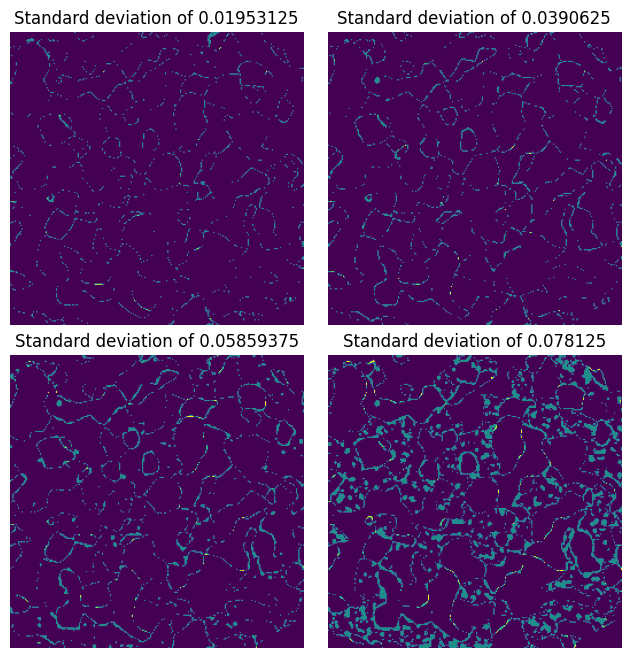

In [ ]:
# Initialize lists to store accuracy and noise level
accuracies_gauss = [results[1]]
noises_gauss = [0]

figure = plt.figure(figsize=(8, 8))
plt.subplots_adjust(wspace=0.05, hspace=0.1)  # Adjust the spacing between subplots

for pixel in range(1,21):
    # Set noise
    NOISE = 1/256 * pixel # pixel color's difference
    idx = 0

    # Add Gaussian noise to the test data
    x_test_noise = gaussian_noise(x_test)
    sample_image = x_test_noise[idx]
    sample_mask = y_test[idx]

    if pixel % 5 == 0:
        pred_mask = prediction(sample_image)
        subplot_index = pixel // 5
        ax = figure.add_subplot(2, 2, subplot_index)
        ax.set_title(f'Standard deviation of {NOISE}')
        ax.imshow(tf.keras.preprocessing.image.array_to_img(visualize_difference(pred_mask, sample_mask)))
        ax.axis('off')

    # Evaluate model accuracy with the noisy test data
    acc = model.evaluate(x_test_noise, y_test_cat, verbose=0)[1]

    accuracies_gauss.append(acc)
    noises_gauss.append(NOISE)

img_path = os.path.join(main_path, 'model_final', f'gaussian_noise.png')
plt.savefig(img_path)

# Show the figure
plt.show()

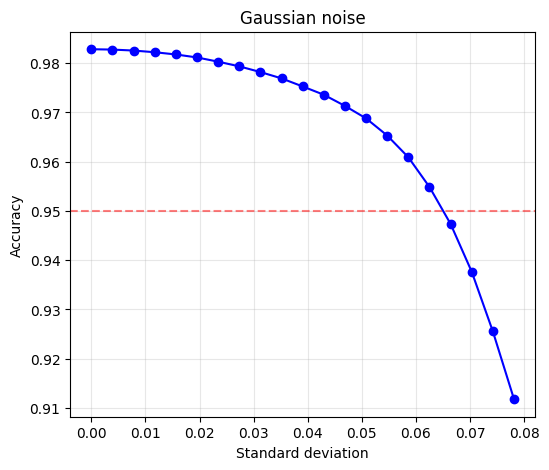

In [ ]:
# Plotting
plt.figure(figsize=(6, 5))
plt.plot(noises_gauss, accuracies_gauss, marker='o', linestyle='-', color='b', label='Accuracy vs Pixels')

# Adding labels and title
plt.xlabel('Standard deviation')
plt.ylabel('Accuracy')
plt.title('Gaussian noise')
plt.grid(True, alpha=0.3)

# Draw a horizontal line at y=0.95
plt.axhline(y=0.95, color='red', linestyle='--', label='Threshold', alpha=0.5)

img_path = os.path.join(main_path, 'model_final', f'gaussian_noise_accuracy.png')
plt.savefig(img_path)

# Show the plot
plt.show()

### Blur Noise

In [ ]:
from scipy.ndimage import gaussian_filter

# Apply Gaussian blur to a batch of images.
def blur_noise(images):
    filtered_images = np.zeros_like(images, dtype=np.float32)
    for i in range(images.shape[0]):
        filtered_images[i, :, :, 0] = gaussian_filter(images[i, :, :, 0], sigma=NOISE)
    return filtered_images

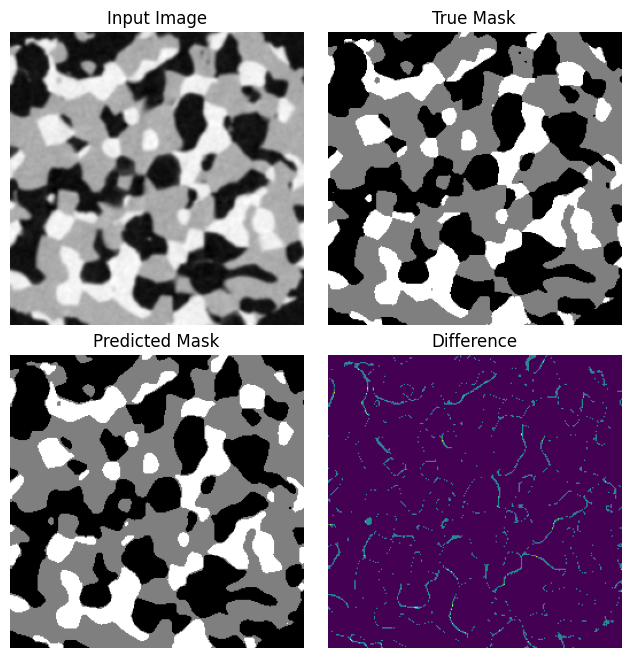

In [ ]:
sample_image = gaussian_filter(x_test[0], sigma=1)
sample_mask=y_test[0]

pred = prediction(sample_image)
show_predictions(sample_image, sample_mask)

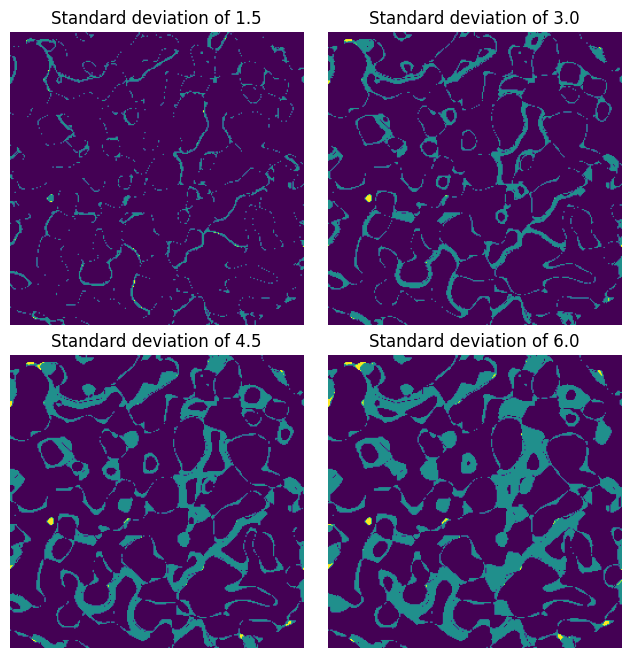

In [ ]:
# Initialize lists to store accuracy and noise level
accuracies_blur = [results[1]]
noises_blur = [0]

figure = plt.figure(figsize=(8, 8))
plt.subplots_adjust(wspace=0.05, hspace=0.1)  # Adjust the spacing between subplots

for blur_level in range(1, 21):
    # Set noise
    NOISE = 0.3 * blur_level # pixel color's difference
    idx = 0

    # Add Gaussian noise to the test data
    x_test_noise = blur_noise(x_test)
    sample_image = x_test_noise[idx]
    sample_mask = y_test[idx]

    if blur_level % 5 == 0:
        pred_mask = prediction(sample_image)
        subplot_index = blur_level // 5
        ax = figure.add_subplot(2, 2, subplot_index)
        ax.set_title(f'Standard deviation of {NOISE}')
        ax.imshow(tf.keras.preprocessing.image.array_to_img(visualize_difference(pred_mask, sample_mask)))
        ax.axis('off')

    # Evaluate model accuracy with the noisy test data
    acc = model.evaluate(x_test_noise, y_test_cat, verbose=0)[1]

    accuracies_blur.append(acc)
    noises_blur.append(NOISE)

img_path = os.path.join(main_path, 'model_final', f'blur_noise.png')
plt.savefig(img_path)

# Show the figure
plt.show()

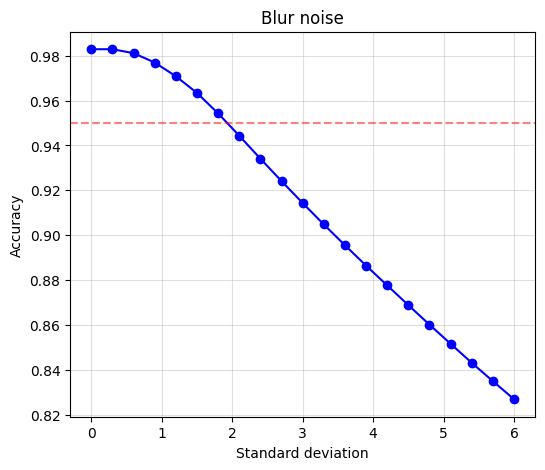

In [ ]:
# Plotting
plt.figure(figsize=(6, 5))
plt.plot(noises_blur, accuracies_blur, marker='o', linestyle='-', color='b', label='Accuracy vs Pixels')

# Adding labels and title
plt.xlabel('Standard deviation')
plt.ylabel('Accuracy')
plt.title('Blur noise')
plt.grid(True, alpha=0.4)

# Draw a horizontal line at y=0.95
plt.axhline(y=0.95, color='red', linestyle='--', label='Threshold', alpha=0.5)

img_path = os.path.join(main_path, 'model_final', f'blur_noise_accuracy.png')
plt.savefig(img_path)

# Show the plot
plt.show()

## Noisy model

### Generate gaussian noise nodel

In [ ]:
# Set the level of Gaussian noise
NOISE = 0.08

# Apply Gaussian noise to a proportion of images in a dataset.
def apply_gaussian_noise(dataset, proportion_to_transform):
    dataset_gauss = np.copy(dataset)
    num_images_to_transform = int(proportion_to_transform * dataset_gauss.shape[0])
    indices_to_transform = np.random.choice(dataset_gauss.shape[0], size=num_images_to_transform, replace=False)
    dataset_gauss[indices_to_transform] = gaussian_noise(dataset_gauss[indices_to_transform])
    return dataset_gauss, indices_to_transform

# Apply Gaussian noise to a proportion of images in the training, validation, and test sets
x_train_gauss, _ = apply_gaussian_noise(x_train, 0.1)
x_valid_gauss, _ = apply_gaussian_noise(x_valid, 0.1)
x_test_gauss, idx = apply_gaussian_noise(x_test, 0.5)

(If the model has already been trained, proceed to load the model)

In [ ]:
saved_model_path = os.path.join(main_path, 'model_final', 'saved_model_gauss.keras')

model_gauss = load_saved_model(saved_model_path)

(If the model has not undergone training yet)

In [ ]:
# Train the model on the dataset with added Gaussian noise
adam_optimizer = Adam(learning_rate=LR)

model_gauss = get_model()
model_gauss.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=[pixel_accuracy, mean_iou, dice_coefficient, precision, recall, f1_score])
history_gauss = model_gauss.fit(x_train_gauss, y_train_cat,
                          batch_size = BATCH,
                          verbose=1,
                          epochs=EPOCHS,
                          validation_data=(x_valid_gauss, y_valid_cat),
                          shuffle=False,
                          callbacks=[early_stopping, reduce_lr])

Epoch 1/50
22/22 [==============================] - 14s 237ms/step - loss: 1.8752 - pixel_accuracy: 0.6553 - mean_iou: 0.0428 - dice_coefficient: 0.0740 - precision: 0.2206 - recall: 0.0582 - f1_score: 0.0740 - val_loss: 1.0132 - val_pixel_accuracy: 0.6667 - val_mean_iou: 0.0000e+00 - val_dice_coefficient: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0100
Epoch 2/50
22/22 [==============================] - 4s 193ms/step - loss: 0.9203 - pixel_accuracy: 0.6772 - mean_iou: 0.1504 - dice_coefficient: 0.2445 - precision: 0.4692 - recall: 0.1794 - f1_score: 0.2445 - val_loss: 0.8175 - val_pixel_accuracy: 0.7009 - val_mean_iou: 0.2803 - val_dice_coefficient: 0.4375 - val_precision: 0.5856 - val_recall: 0.3495 - val_f1_score: 0.4375 - lr: 0.0100
Epoch 3/50
22/22 [==============================] - 4s 197ms/step - loss: 0.6958 - pixel_accuracy: 0.7904 - mean_iou: 0.4549 - dice_coefficient: 0.6165 - precision: 0.7702 - recall: 0.5188 - f1_sco

### Evaluation of the Gaussian model


In [ ]:
results_gauss = model_gauss.evaluate(x_test_gauss, y_test_cat, verbose=0)
dict(zip(model_gauss.metrics_names, results_gauss))

{'loss': 0.13226766884326935,
 'pixel_accuracy': 0.9645757675170898,
 'mean_iou': 0.8989903926849365,
 'dice_coefficient': 0.9468032717704773,
 'precision': 0.9478792548179626,
 'recall': 0.9457297325134277,
 'f1_score': 0.9468031525611877}

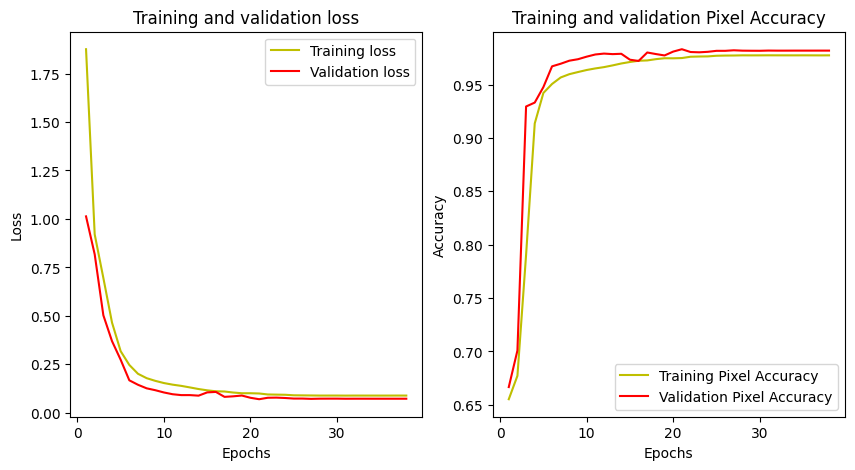

In [ ]:
loss = history_gauss.history['loss']
val_loss = history_gauss.history['val_loss']
acc = history_gauss.history['pixel_accuracy']
val_acc = history_gauss.history['val_pixel_accuracy']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'y', label='Training Pixel Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Pixel Accuracy')
plt.title('Training and validation Pixel Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig(os.path.join(main_path, 'model_final', f'model_gauss_metrics.png'))
plt.show()

In [ ]:
def prediction_noise(sample_image):
    sample_image = np.expand_dims(sample_image, 0)
    prediction = model_gauss.predict(sample_image, verbose=0)
    pred_mask = create_mask(prediction)
    return pred_mask

def show_predictions_noise(sample_image, sample_mask):
    pred_mask = prediction_noise(sample_image)
    display_sample([sample_image, sample_mask, pred_mask])

### Vizualizations of Gaussian model results

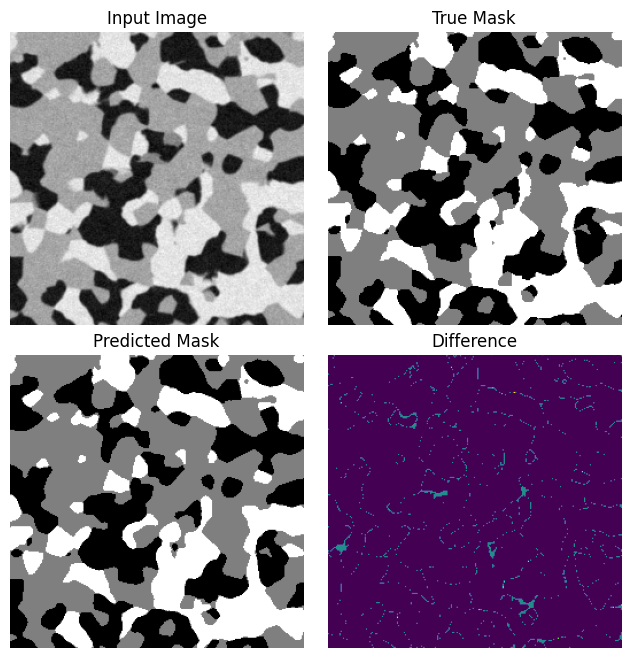

In [ ]:
sample_image = x_test_gauss[idx[0]]
sample_mask=y_test[idx[0]]
show_predictions_noise(sample_image, sample_mask)

In [ ]:
model_gauss.save(os.path.join(main_path, 'model_final', 'saved_model_gauss.keras'))

### Generate blur noise model

In [ ]:
# Set the level of blur noise
NOISE = 3

# Apply Gaussian blur noise to a proportion of images in a dataset.
def apply_blur_noise(dataset, proportion_to_transform):
    dataset_blur = np.copy(dataset)
    num_images_to_transform = int(proportion_to_transform * dataset_blur.shape[0])
    indices_to_transform = np.random.choice(dataset_blur.shape[0], size=num_images_to_transform, replace=False)
    dataset_blur[indices_to_transform] = blur_noise(dataset_blur[indices_to_transform])
    return dataset_blur, indices_to_transform

# Apply blur noise to a proportion of images in the training, validation, and test sets
x_train_blur, _ = apply_blur_noise(x_train, 0.1)
x_valid_blur, _ = apply_blur_noise(x_valid, 0.1)
x_test_blur, idx = apply_blur_noise(x_test, 0.5)

(If the model has already been trained, proceed to load the model)

In [ ]:
saved_model_path = os.path.join(main_path, 'model_final', 'saved_model_blur.keras')

model_blur = load_saved_model(saved_model_path)

(If the model has not undergone training yet)

In [ ]:
# Train the model on the dataset with added blur noise
adam_optimizer = Adam(learning_rate=LR)

model_blur = get_model()
model_blur.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=[pixel_accuracy, mean_iou, dice_coefficient, precision, recall, f1_score])
history_blur = model_blur.fit(x_train_blur, y_train_cat,
                          batch_size = BATCH,
                          verbose=1,
                          epochs=EPOCHS,
                          validation_data=(x_valid_blur, y_valid_cat),
                          shuffle=False,
                          callbacks=[early_stopping, reduce_lr])

Epoch 1/50
22/22 [==============================] - 13s 235ms/step - loss: 1.2029 - pixel_accuracy: 0.6562 - mean_iou: 0.0725 - dice_coefficient: 0.1299 - precision: 0.4337 - recall: 0.0871 - f1_score: 0.1299 - val_loss: 1.0599 - val_pixel_accuracy: 0.6667 - val_mean_iou: 0.0000e+00 - val_dice_coefficient: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0100
Epoch 2/50
22/22 [==============================] - 4s 199ms/step - loss: 1.0346 - pixel_accuracy: 0.6575 - mean_iou: 0.0933 - dice_coefficient: 0.1655 - precision: 0.4095 - recall: 0.1089 - f1_score: 0.1655 - val_loss: 0.9320 - val_pixel_accuracy: 0.6266 - val_mean_iou: 0.0974 - val_dice_coefficient: 0.1773 - val_precision: 0.3336 - val_recall: 0.1207 - val_f1_score: 0.1773 - lr: 0.0100
Epoch 3/50
22/22 [==============================] - 4s 195ms/step - loss: 0.7975 - pixel_accuracy: 0.7153 - mean_iou: 0.2760 - dice_coefficient: 0.4073 - precision: 0.5966 - recall: 0.3263 - f1_sco

### Evaluation of the blur model

In [ ]:
results_blur = model_blur.evaluate(x_test_blur, y_test_cat, verbose=0)
dict(zip(model_blur.metrics_names, results_blur))

{'loss': 0.18000172078609467,
 'pixel_accuracy': 0.955763578414917,
 'mean_iou': 0.875525176525116,
 'dice_coefficient': 0.9336000084877014,
 'precision': 0.9342399835586548,
 'recall': 0.9329609274864197,
 'f1_score': 0.9335999488830566}

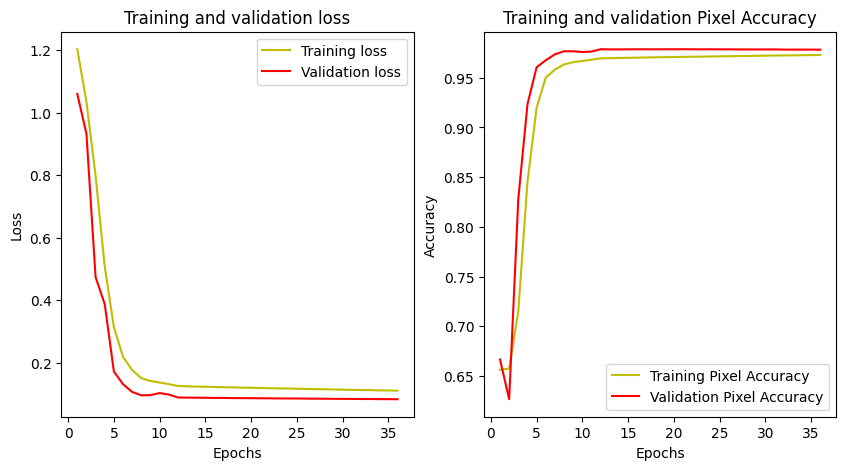

In [ ]:
loss = history_blur.history['loss']
val_loss = history_blur.history['val_loss']
acc = history_blur.history['pixel_accuracy']
val_acc = history_blur.history['val_pixel_accuracy']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'y', label='Training Pixel Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Pixel Accuracy')
plt.title('Training and validation Pixel Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig(os.path.join(main_path, 'model_final', f'model_blur_metrics.png'))
plt.show()

### Visualizations of blur model results

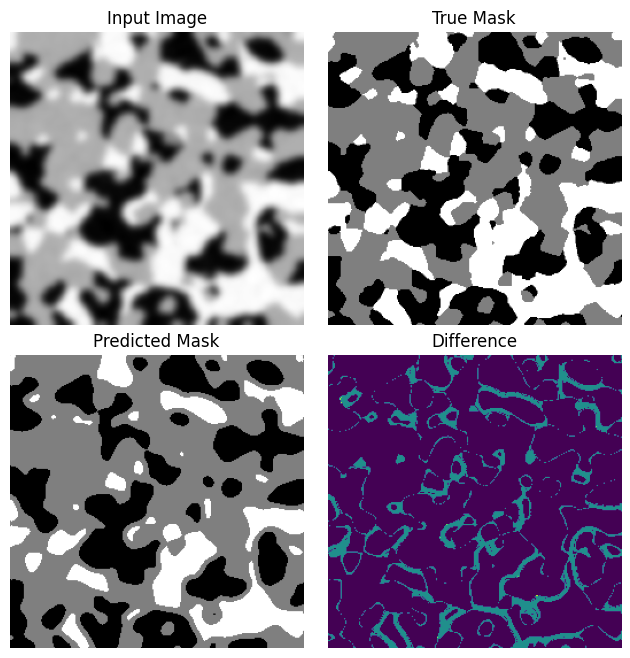

In [ ]:
sample_image = x_test_blur[idx[0]]
sample_mask=y_test[idx[0]]
show_predictions_noise(sample_image, sample_mask)

In [ ]:
model_blur.save(os.path.join(main_path, 'model_final', 'saved_model_blur.keras'))